# Validate array vs RNA-seq modules

This notebook examines the composition of the modules is a few ways:
1. This notebook compares the modules found using array data vs RNA-seq data. We would expect the modules to be similar
2. This notebook also examines the enrichment of KEGG pathways within the modules

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import scipy
import scipy.stats as ss
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.multitest
from sklearn.cluster import DBSCAN, AgglomerativeClustering, AffinityPropagation
from scripts import utils, paths

np.random.seed(1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# User params
num_singular_values_log = 100

# Clustering method
# Choices: {"dbscan", "hierarchal", "affinity"}
cluster_method = "affinity"

# DBSCAN params
density_threshold = 8

# Hierarchical clustering params
hier_threshold = 8
link_dist = "average"

# Affinity params
affinity_damping = 0.6

In [3]:
# Load array expression data
pao1_array_compendium_filename = paths.ARRAY_COMPENDIUM_TO_COMPARE

In [4]:
pao1_array_compendium = pd.read_csv(
    pao1_array_compendium_filename, sep="\t", header=0, index_col=0
)

In [5]:
print(pao1_array_compendium.shape)
pao1_array_compendium.head()

(501, 5543)


PA2398    PA4139  \
GSM1237739_M9_PAOSX_4_5105960065306105041141039...  10.717242  9.301182   
GSM871978.CEL                                        6.263572  6.147795   
GSM1177846_PAO1-AMV-2.CEL                            8.907773  7.280486   
GSM871971.CEL                                        7.265860  6.264013   
GSM251206.CEL                                        6.496274  6.713797   

                                                       PA5304    PA5291  \
GSM1237739_M9_PAOSX_4_5105960065306105041141039...  10.546296  6.965815   
GSM871978.CEL                                        8.822093  6.852434   
GSM1177846_PAO1-AMV-2.CEL                            9.796465  6.565418   
GSM871971.CEL                                        9.560378  6.954073   
GSM251206.CEL                                       11.321354  6.542996   

                                                      PA1068    PA1652  \
GSM1237739_M9_PAOSX_4_5105960065306105041141039...  7.933023  5.844677   
GSM871978.CEL                                       7.482883  6.415905   
GSM1177846_PAO1-AMV-2.CEL                           7.753219  5.794461   
GSM871971.CEL                                       6.860596  6.480814   
GSM251206.CEL                                       8.472091  5.750265   

                                                      PA0116    PA4554  \
GSM1237739_M9_PAOSX_4_5105960065306105041141039...  7.175061  8.771856   
GSM871978.CEL                                       7.846706  7.093168   
GSM1177846_PAO1-AMV-2.CEL                           7.489991  7.721875   
GSM871971.CEL                                       7.825187  7.418435   
GSM251206.CEL                                       8.084865  8.287631   

                                                      PA1067    PA1956  ...  \
GSM1237739_M9_PAOSX_4_5105960065306105041141039...  5.589998  5.804320  ...   
GSM871978.CEL                                       6.246546  7.158197  ...   
GSM1177846_PAO1-AMV-2.CEL                           5.305382  5.384820  ...   
GSM871971.CEL                                       6.007698  7.173383  ...   
GSM251206.CEL                                       5.641227  5.902264  ...   

                                                      PA1296     PA1337  \
GSM1237739_M9_PAOSX_4_5105960065306105041141039...  8.049779  11.561583   
GSM871978.CEL                                       7.489703   7.653476   
GSM1177846_PAO1-AMV-2.CEL                           8.184725   9.929479   
GSM871971.CEL                                       6.287589   8.356438   
GSM251206.CEL                                       8.440391  10.659902   

                                                      PA4024    PA1926  \
GSM1237739_M9_PAOSX_4_5105960065306105041141039...  7.774840  7.244791   
GSM871978.CEL                                       6.797381  6.948223   
GSM1177846_PAO1-AMV-2.CEL                           8.077618  7.162045   
GSM871971.CEL                                       6.050691  6.951431   
GSM251206.CEL                                       6.712292  8.743952   

                                                      PA3784    PA1974  \
GSM1237739_M9_PAOSX_4_5105960065306105041141039...  6.739128  6.275518   
GSM871978.CEL                                       6.753653  5.920454   
GSM1177846_PAO1-AMV-2.CEL                           9.160910  5.795577   
GSM871971.CEL                                       6.598293  6.499120   
GSM251206.CEL                                       6.756202  5.975163   

                                                       PA5553    PA0073  \
GSM1237739_M9_PAOSX_4_5105960065306105041141039...  10.690451  8.234830   
GSM871978.CEL                                        8.052674  9.473873   
GSM1177846_PAO1-AMV-2.CEL                            8.299442  7.721728   
GSM871971.CEL                                        7.698821  8.253621   
GSM251206.CEL                                       10.119247  8.187222 

## Get correlation matrix for array compendium

In [6]:
# Correlation
pao1_array_corr_original = pao1_array_compendium.corr()

Note: Below we plotted the heatmap of the array data to confirm that it has the same issue as the RNA-seq data - there is one large cluster

CPU times: user 2min 9s, sys: 880 ms, total: 2min 10s
Wall time: 2min 9s


Text(0.5, 1.05, 'Correlation of raw PAO1 genes (array compendium)')

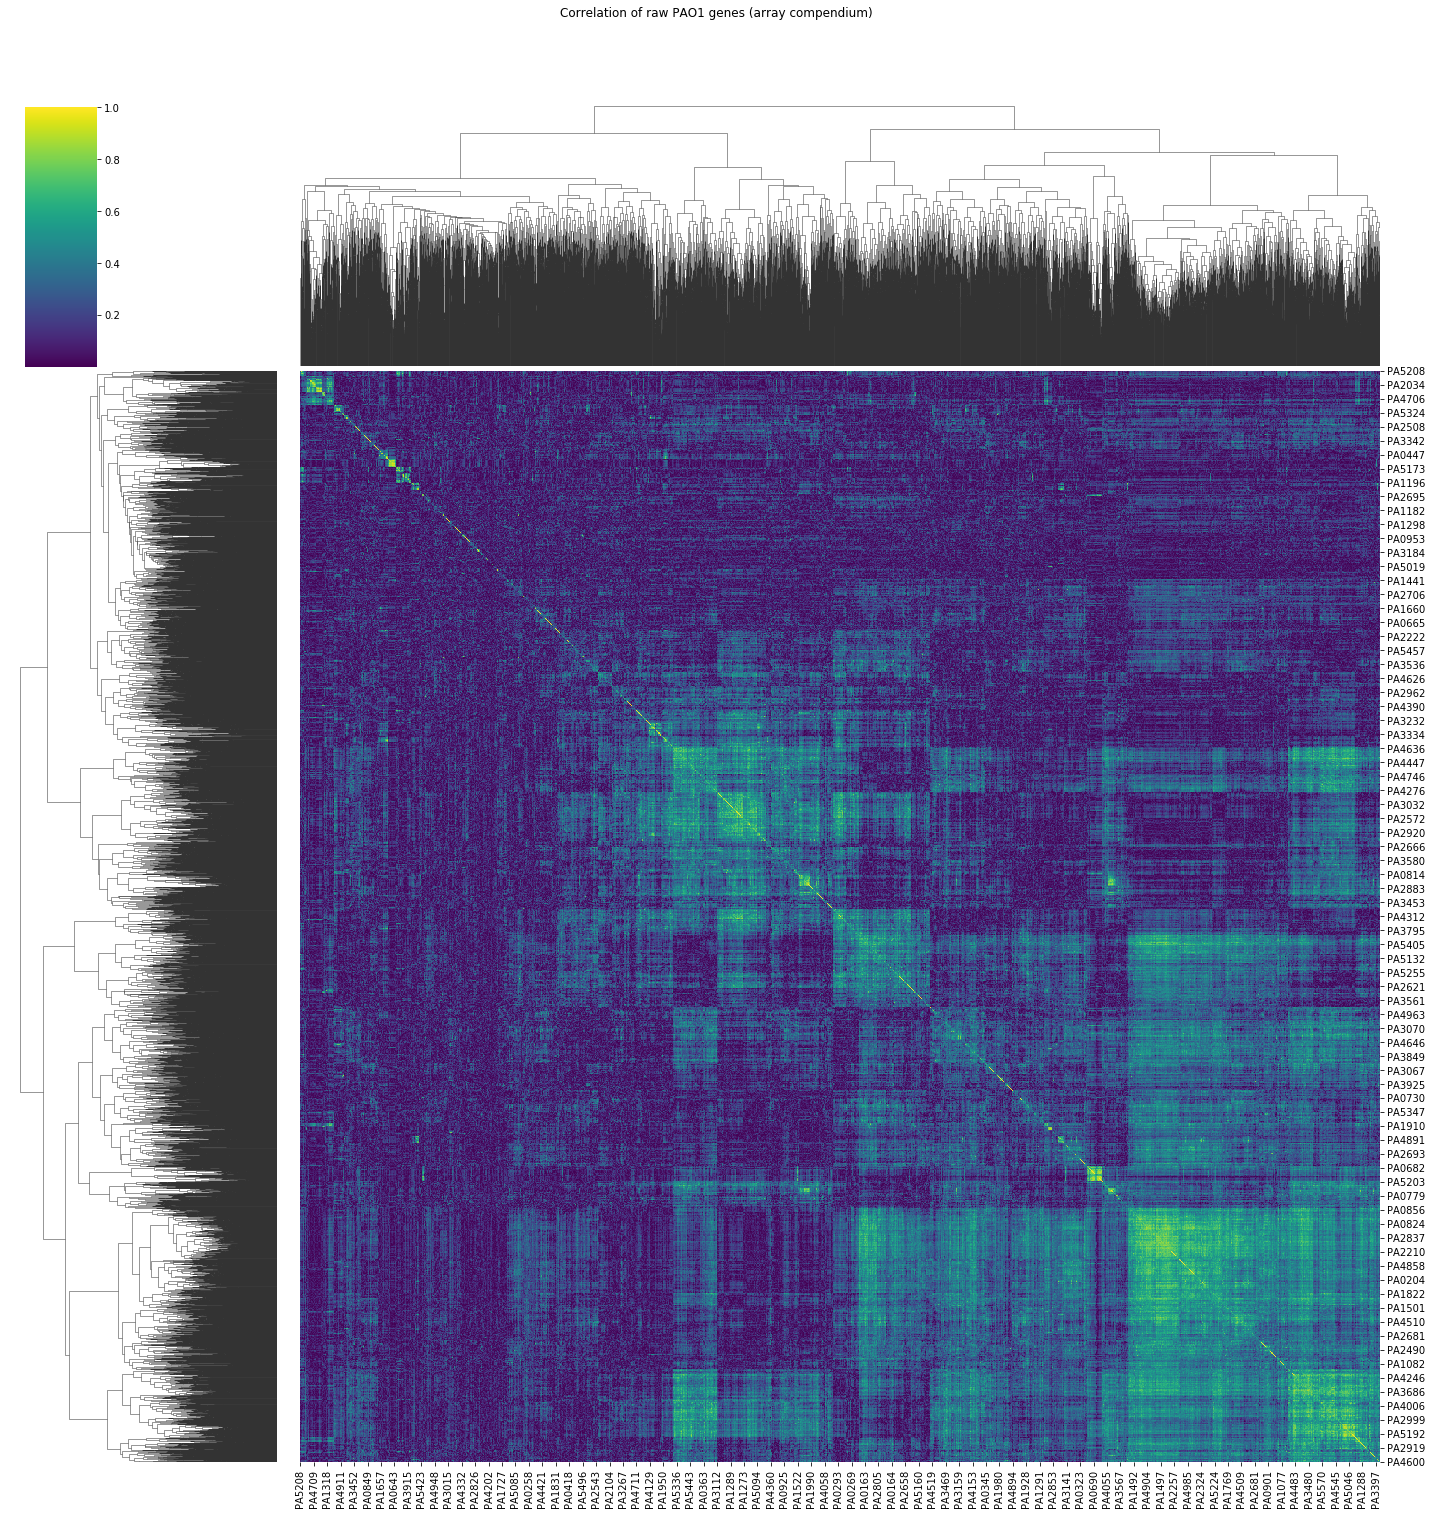

In [7]:
%%time
# Plot heatmap
o1 = sns.clustermap(pao1_array_corr_original.abs(), cmap="viridis", figsize=(20, 20))
o1.fig.suptitle("Correlation of raw PAO1 genes (array compendium)", y=1.05)

In [8]:
# Transpose compendia to be gene x sample
# Here we're interested in how genes cluster
pao1_array_compendium_T = pao1_array_compendium.T

In [9]:
# log transform data
pao1_array_compendium_log10 = np.log10(1 + pao1_array_compendium_T)

In [10]:
# Apply SVD
array_U, array_s, array_Vh = np.linalg.svd(
    pao1_array_compendium_log10, full_matrices=False
)

In [11]:
# Convert ndarray to df to use corr()
array_U_df = pd.DataFrame(data=array_U, index=pao1_array_compendium_T.index)

In [12]:
# Correlation of U
# Since `corr()` computes pairwise correlation of columns we need to invert U
pao1_array_corr_log_spell = array_U_df.iloc[:, :num_singular_values_log].T.corr()

Note: Here we plot the heatmaps to verify that the correlation of log + SPELL transformed data looks as expected (i.e. there is not a single large cluster)

CPU times: user 2min 9s, sys: 832 ms, total: 2min 10s
Wall time: 2min 9s


Text(0.5, 1.05, 'log transform + SPELL corrected using 100 vectors (PAO1 array)')

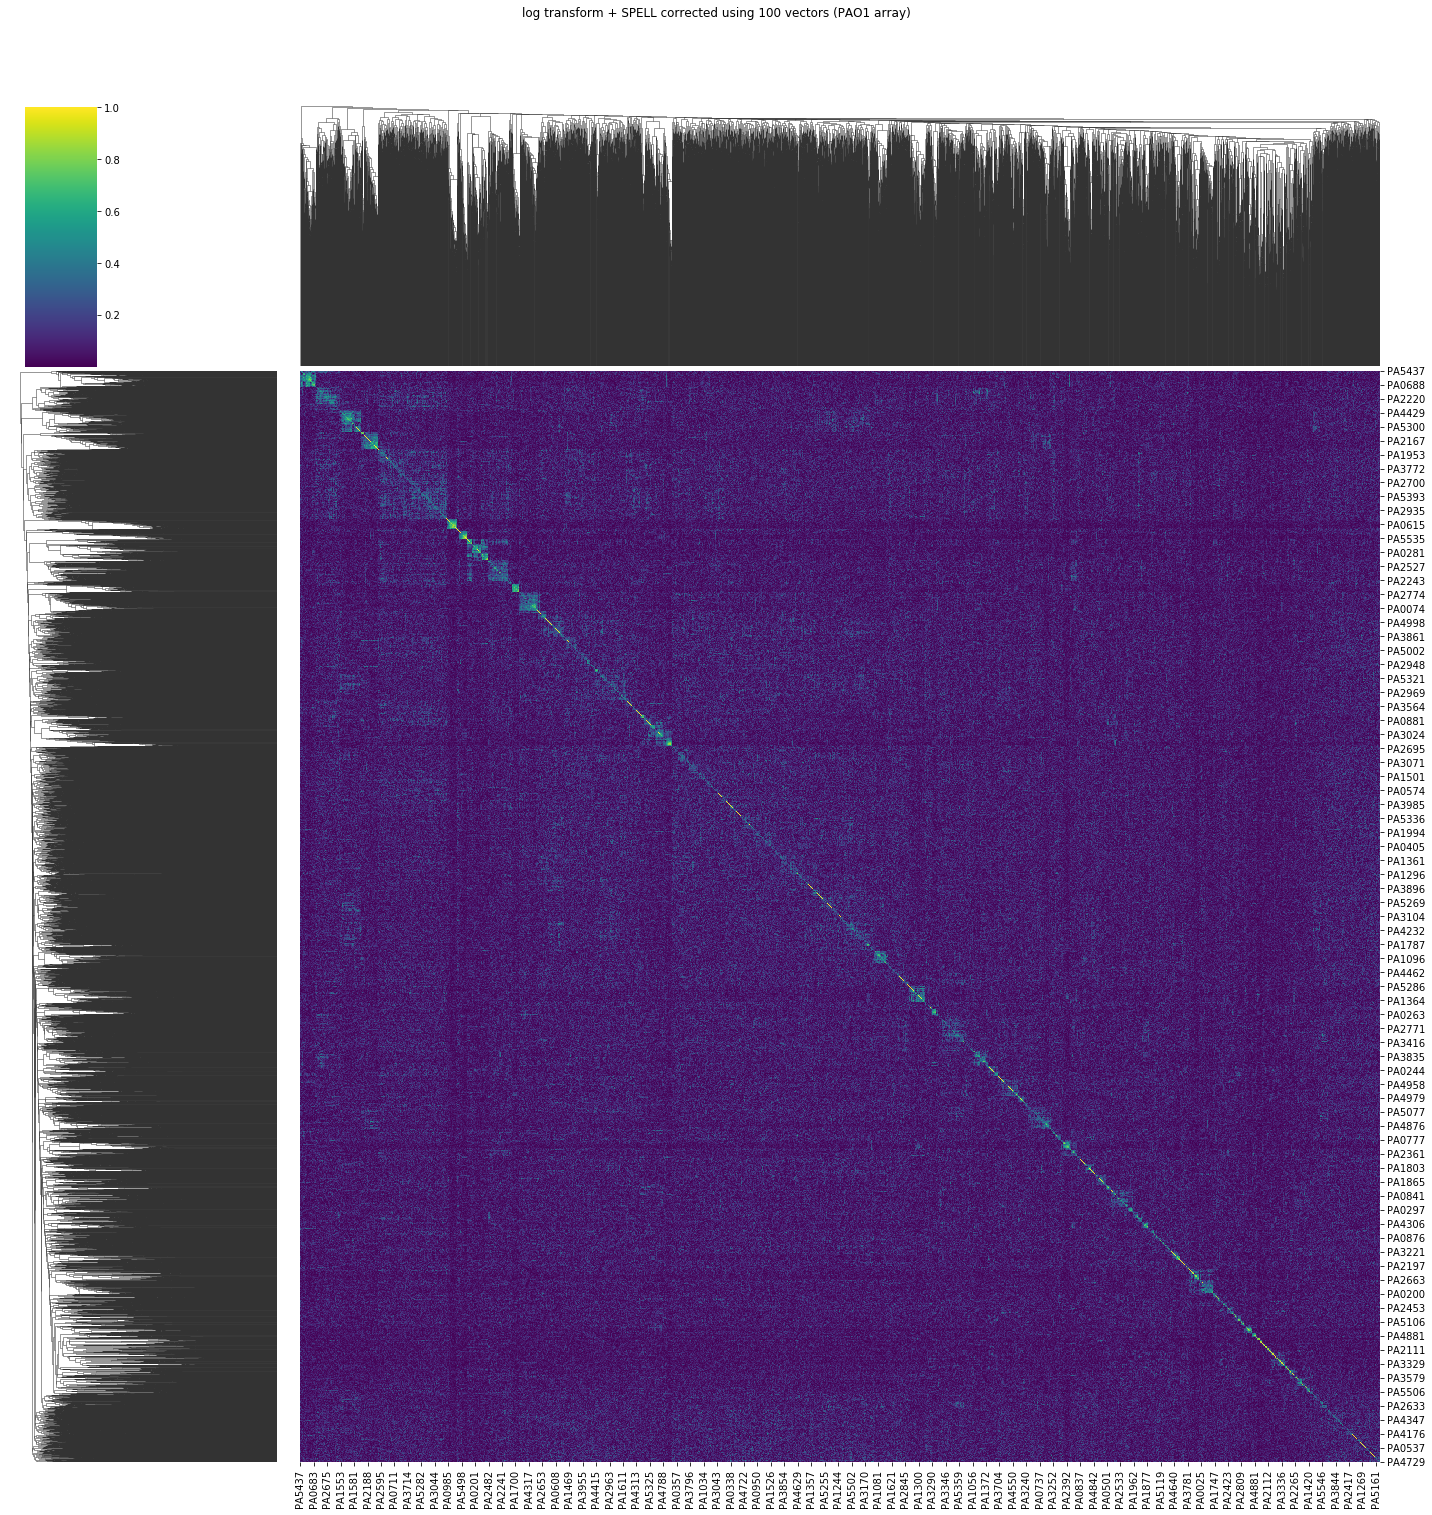

In [13]:
%%time
# Plot heatmap
h1a = sns.clustermap(pao1_array_corr_log_spell.abs(), cmap="viridis", figsize=(20, 20))
h1a.fig.suptitle(
    f"log transform + SPELL corrected using {num_singular_values_log} vectors (PAO1 array)",
    y=1.05,
)

## Clustering and get module membership for array compendium

In [14]:
# Clustering using DBSCAN
if cluster_method == "dbscan":
    pao1_array_clustering = DBSCAN(eps=density_threshold).fit(pao1_array_corr_log_spell)

In [15]:
# Clustering using hierarchal clustering
if cluster_method == "hierarchal":
    pao1_array_clustering = AgglomerativeClustering(
        n_clusters=None, distance_threshold=hier_threshold, linkage=link_dist
    ).fit(ppao1_array_corr_log_spell)

In [16]:
# Clustering using affinity propogation
if cluster_method == "affinity":
    pao1_array_clustering = AffinityPropagation(random_state=0).fit(
        pao1_array_corr_log_spell
    )

In [17]:
# Get module membership for a single threshold
# Format and save output to have columns: gene_id | group_id
pao1_array_membership_df = pd.DataFrame(
    data={"module id": pao1_array_clustering.labels_},
    index=pao1_array_corr_log_spell.index,
)
pao1_array_membership_df["module id"].value_counts()

181    45
263    33
473    33
188    31
516    28
       ..
230     3
232     3
18      3
162     3
391     3
Name: module id, Length: 559, dtype: int64

In [18]:
pao1_array_membership_df.head()

module id
PA2398        298
PA4139        137
PA5304        357
PA5291        205
PA1068         21

### Load RNA-seq module membership

The modules for the RNA-seq compendium were generated using the same procedure as we just performed using the array compendium. The code for performing this module detection can be found in the previous 1_ and 2_ notebooks in this directory.

In [19]:
pao1_rnaseq_membership_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pao1_modules_{cluster_method}_all.tsv"
)

In [20]:
pao1_rnaseq_membership_df = pd.read_csv(
    pao1_rnaseq_membership_filename, sep="\t", index_col=0, header=0
)

In [21]:
pao1_rnaseq_membership_df.head()

module id
PA0001        415
PA0002        573
PA0003         92
PA0004        567
PA0005          0

## Compare composition of modules between array and RNA-seq

For a given RNA-seq module, find the best fit module in the array compendium using the hypergeometric test?

For rna-seq data, `modules id` is the cluster id. We can then look up which array cluster these genes from the rna-seq cluster map to. Here we are looking to see if modules are consistent (i.e. Do genes that cluster together in the RNA-seq compendium also cluster in the array compendium)?

To compare the consistency we use the [hypergeometric test](https://alexlenail.medium.com/understanding-and-implementing-the-hypergeometric-test-in-python-a7db688a7458) which will allow us to examine the over-representation of genes from the RNA-seq module within an array module and vice versa.

In [22]:
# As a baseline make a membership df mapping genes to a shuffled set of module ids
pao1_rnaseq_membership_shuffle_df = pao1_rnaseq_membership_df.copy()
pao1_rnaseq_membership_shuffle_df["module id"] = np.random.permutation(
    pao1_rnaseq_membership_shuffle_df["module id"].values
)

pao1_array_membership_shuffle_df = pao1_array_membership_df.copy()
pao1_array_membership_shuffle_df["module id"] = np.random.permutation(
    pao1_array_membership_shuffle_df["module id"].values
)

In [23]:
pao1_rnaseq_membership_shuffle_df.head()

module id
PA0001        238
PA0002        567
PA0003        559
PA0004         11
PA0005        468

In [24]:
pao1_array_membership_shuffle_df.head()

module id
PA2398        462
PA4139        544
PA5304        308
PA5291        201
PA1068        406

In [25]:
# Array to RNA-seq
# Given an array module, look for the rnaseq module with the most overlap/significant p-value
def map_array_to_rnaseq_modules(array_membership_df, rnaseq_membership_df):
    total_array_genes = array_membership_df.shape[0]

    rows = []
    # For each array module
    for array_group_name, array_df_group in array_membership_df.groupby("module id"):
        num_array_genes = array_df_group.shape[0]

        # Find the RNA-seq module with the best overlap
        for rnaseq_group_name, rnaseq_df_group in rnaseq_membership_df.groupby(
            "module id"
        ):
            num_rnaseq_genes = rnaseq_df_group.shape[0]

            shared_genes = set(array_df_group.index).intersection(rnaseq_df_group.index)
            num_shared_genes = len(shared_genes)

            # Equivalent to performing a Fisher's exact test with
            #                      | in array module | not in array module
            # -------------------------------------------------------------
            # in RNA-seq module    |              |
            # --------------------------------------------------------------
            # not in RNA-seq module|              |
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html
            pval = ss.hypergeom.sf(
                num_shared_genes - 1,
                total_array_genes,
                num_array_genes,
                num_rnaseq_genes,
            )

            # Try Fisher's exact test too
            # Looks like the results are the same
            # rnaseq_only =  len(set(rnaseq_df_group.index).difference(array_df_group.index))
            # array_only = len(set(array_df_group.index).difference(rnaseq_df_group.index))
            # neither_1 = set(array_membership_df.index).difference(array_df_group.index)
            # neither = len(set(neither_1).difference(rnaseq_df_group.index))
            # observed_contingency_table = np.array(
            #    [
            #        [num_shared_genes, rnaseq_only],
            #        [array_only, neither],
            #    ]
            # )

            # H0: The probability that the gene is core is the same
            # whether or not you're in the module or outside
            # H1: The probability that a gene is core is higher or lower inside the module
            # than outside the module
            # odds_ratio, pval = scipy.stats.fisher_exact(
            #    observed_contingency_table, alternative="greater"
            # )
            rows.append(
                {
                    "array module id": array_group_name,
                    "rnaseq module id": rnaseq_group_name,
                    "p-value": pval,
                    "num shared genes": num_shared_genes,
                    "size array module": num_array_genes,
                    "size rnaseq module": num_rnaseq_genes,
                }
            )

    array_to_rnaseq_df = pd.DataFrame(rows)

    # Get corrected pvalues
    (
        reject_,
        pvals_corrected_,
        alphacSidak,
        alphacBonf,
    ) = statsmodels.stats.multitest.multipletests(
        array_to_rnaseq_df["p-value"].values,
        alpha=0.05,
        method="fdr_bh",
        is_sorted=False,
    )

    array_to_rnaseq_df["corrected p-value"] = pvals_corrected_

    # Select best module mapping
    best_array_to_rnaseq_df = array_to_rnaseq_df.groupby("array module id").min()

    return best_array_to_rnaseq_df

In [26]:
%%time
array_to_rnaseq_true = map_array_to_rnaseq_modules(
    pao1_array_membership_df, pao1_rnaseq_membership_df
)

CPU times: user 20.4 s, sys: 84 ms, total: 20.5 s
Wall time: 20.5 s


In [27]:
print(array_to_rnaseq_true.shape)
array_to_rnaseq_true.head()

(559, 6)


rnaseq module id       p-value  num shared genes  \
array module id                                                     
0                               0  2.282996e-12                 0   
1                               0  9.668863e-32                 0   
2                               0  3.337737e-11                 0   
3                               0  3.814412e-05                 0   
4                               0  7.049880e-10                 0   

                 size array module  size rnaseq module  corrected p-value  
array module id                                                            
0                                9                   2       4.447346e-09  
1                               14                   2       1.479912e-27  
2                                9                   2       5.391116e-08  
3                                7                   2       2.961467e-02  
4                                6                   2       9.601727e-07

In [28]:
%%time
array_to_rnaseq_shuffle = map_array_to_rnaseq_modules(
    pao1_array_membership_df, pao1_rnaseq_membership_shuffle_df
)

CPU times: user 20.3 s, sys: 40 ms, total: 20.4 s
Wall time: 20.4 s


In [29]:
print(array_to_rnaseq_shuffle.shape)
array_to_rnaseq_shuffle.head()

(559, 6)


rnaseq module id   p-value  num shared genes  \
array module id                                                 
0                               0  0.009707                 0   
1                               0  0.000164                 0   
2                               0  0.008095                 0   
3                               0  0.010065                 0   
4                               0  0.007557                 0   

                 size array module  size rnaseq module  corrected p-value  
array module id                                                            
0                                9                   2                1.0  
1                               14                   2                1.0  
2                                9                   2                1.0  
3                                7                   2                1.0  
4                                6                   2                1.0

In [30]:
# RNA-seq to array
# Given a RNA-seq module, look for the array module with the most overlap/significant p-value
def map_rnaseq_to_array_modules(rnaseq_membership_df, array_membership_df):
    total_rnaseq_genes = rnaseq_membership_df.shape[0]

    rows = []
    # For each rna-seq module
    for rnaseq_group_name, rnaseq_df_group in rnaseq_membership_df.groupby("module id"):
        num_rnaseq_genes = rnaseq_df_group.shape[0]

        # Find the array module with the best overlap
        for array_group_name, array_df_group in array_membership_df.groupby(
            "module id"
        ):
            num_array_genes = array_df_group.shape[0]

            shared_genes = set(array_df_group.index).intersection(rnaseq_df_group.index)
            num_shared_genes = len(shared_genes)

            pval = ss.hypergeom.sf(
                num_shared_genes - 1,
                total_rnaseq_genes,
                num_rnaseq_genes,
                num_array_genes,
            )
            rows.append(
                {
                    "rnaseq module id": rnaseq_group_name,
                    "array module id": array_group_name,
                    "p-value": pval,
                    "num shared genes": num_shared_genes,
                    "size rnaseq module": num_rnaseq_genes,
                    "size array module": num_array_genes,
                }
            )

    rnaseq_to_array_df = pd.DataFrame(rows)

    # Get corrected pvalues
    (
        reject_,
        pvals_corrected_,
        alphacSidak,
        alphacBonf,
    ) = statsmodels.stats.multitest.multipletests(
        rnaseq_to_array_df["p-value"].values,
        alpha=0.05,
        method="fdr_bh",
        is_sorted=False,
    )

    rnaseq_to_array_df["corrected p-value"] = pvals_corrected_

    # Select best module mapping
    best_rnaseq_to_array_df = rnaseq_to_array_df.groupby("rnaseq module id").min()

    return best_rnaseq_to_array_df, rnaseq_to_array_df

In [31]:
%%time
rnaseq_to_array_true, rnaseq_to_array_true_all = map_rnaseq_to_array_modules(
    pao1_rnaseq_membership_df, pao1_array_membership_df
)

CPU times: user 20.1 s, sys: 28 ms, total: 20.2 s
Wall time: 20.2 s


In [32]:
print(rnaseq_to_array_true.shape)
rnaseq_to_array_true.head()

(575, 6)


array module id       p-value  num shared genes  \
rnaseq module id                                                    
0                               0  1.185950e-04                 0   
1                               0  3.543612e-05                 0   
2                               0  1.089856e-07                 0   
3                               0  6.456799e-03                 0   
4                               0  7.172929e-03                 0   

                  size rnaseq module  size array module  corrected p-value  
rnaseq module id                                                            
0                                 12                  3           0.078597  
1                                  5                  3           0.027713  
2                                  8                  3           0.000114  
3                                  6                  3           1.000000  
4                                 10                  3           1.000000

In [33]:
rnaseq_to_array_true[rnaseq_to_array_true["num shared genes"] > 0]

Empty DataFrame
Columns: [array module id, p-value, num shared genes, size rnaseq module, size array module, corrected p-value]
Index: []

In [34]:
rnaseq_to_array_true_all[rnaseq_to_array_true_all["num shared genes"] > 0]

rnaseq module id  array module id   p-value  num shared genes  \
31                     0               31  0.012879                 1   
131                    0              131  0.017138                 1   
195                    0              195  0.015010                 1   
205                    0              205  0.025605                 1   
274                    0              274  0.017138                 1   
...                  ...              ...       ...               ...   
321270               574              404  0.011276                 1   
321319               574              453  0.009672                 1   
321357               574              491  0.019261                 1   
321360               574              494  0.022439                 1   
321420               574              554  0.000127                 2   

        size rnaseq module  size array module  corrected p-value  
31                      12                  6           1.000000  
131                     12                  8           1.000000  
195                     12                  7           1.000000  
205                     12                 12           1.000000  
274                     12                  8           1.000000  
...                    ...                ...                ...  
321270                   9                  7           1.000000  
321319                   9                  6           1.000000  
321357                   9                 12           1.000000  
321360                   9                 14           1.000000  
321420                   9                 11           0.082983  

[3501 rows x 7 columns]

In [35]:
%%time
rnaseq_to_array_shuffle, rnaseq_to_array_shuffle_all = map_rnaseq_to_array_modules(
    pao1_rnaseq_membership_df, pao1_array_membership_shuffle_df
)

CPU times: user 20.6 s, sys: 44 ms, total: 20.6 s
Wall time: 20.6 s


In [36]:
print(rnaseq_to_array_shuffle.shape)
rnaseq_to_array_shuffle.head()

(575, 6)


array module id   p-value  num shared genes  \
rnaseq module id                                                
0                               0  0.012879                 0   
1                               0  0.004488                 0   
2                               0  0.007172                 0   
3                               0  0.007530                 0   
4                               0  0.000390                 0   

                  size rnaseq module  size array module  corrected p-value  
rnaseq module id                                                            
0                                 12                  3                1.0  
1                                  5                  3                1.0  
2                                  8                  3                1.0  
3                                  6                  3                1.0  
4                                 10                  3                1.0

## Plot

In [37]:
# Format df for plotting
array_to_rnaseq_true["label"] = "true"
array_to_rnaseq_shuffle["label"] = "shuffle"

array_to_rnaseq_combined = pd.concat([array_to_rnaseq_true, array_to_rnaseq_shuffle])

In [38]:
rnaseq_to_array_true["label"] = "true"
rnaseq_to_array_shuffle["label"] = "shuffle"

rnaseq_to_array_combined = pd.concat([rnaseq_to_array_true, rnaseq_to_array_shuffle])

In [39]:
array_to_rnaseq_combined.head()

rnaseq module id       p-value  num shared genes  \
array module id                                                     
0                               0  2.282996e-12                 0   
1                               0  9.668863e-32                 0   
2                               0  3.337737e-11                 0   
3                               0  3.814412e-05                 0   
4                               0  7.049880e-10                 0   

                 size array module  size rnaseq module  corrected p-value  \
array module id                                                             
0                                9                   2       4.447346e-09   
1                               14                   2       1.479912e-27   
2                                9                   2       5.391116e-08   
3                                7                   2       2.961467e-02   
4                                6                   2       9.601727e-07   

                label  
array module id        
0                true  
1                true  
2                true  
3                true  
4                true

In [40]:
# Test: mean p-values using the true module labels vs shuffle module labels is significant
true_array_to_rnaseq = array_to_rnaseq_combined[
    array_to_rnaseq_combined["label"] == "true"
]["corrected p-value"].values
shuffled_array_to_rnaseq = array_to_rnaseq_combined[
    array_to_rnaseq_combined["label"] == "shuffle"
]["corrected p-value"].values

(stats, pvalue) = scipy.stats.ttest_ind(true_array_to_rnaseq, shuffled_array_to_rnaseq)
print(pvalue)

3.883534221074443e-242


Text(0.5, 1.0, 'Array to RNA-seq modules')

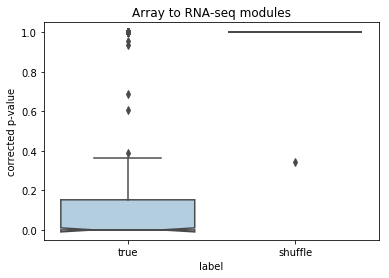

In [41]:
f = sns.boxplot(
    x=array_to_rnaseq_combined["label"],
    y=array_to_rnaseq_combined["corrected p-value"],
    palette="Blues",
    notch=True,
)
f.set_title("Array to RNA-seq modules")

In [42]:
# Test: mean p-values using the true module labels vs shuffle module labels is significant
true_rnaseq_to_array = rnaseq_to_array_combined[
    rnaseq_to_array_combined["label"] == "true"
]["corrected p-value"].values
shuffled_rnaseq_to_array = rnaseq_to_array_combined[
    rnaseq_to_array_combined["label"] == "shuffle"
]["corrected p-value"].values

(stats, pvalue) = scipy.stats.ttest_ind(true_rnaseq_to_array, shuffled_rnaseq_to_array)
print(pvalue)

1.8296273263592384e-245


Text(0.5, 1.0, 'RNA-seq to array modules')

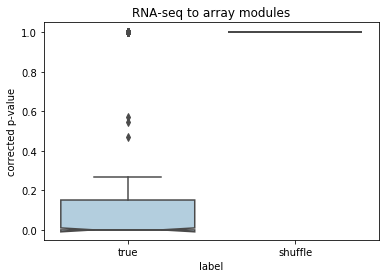

In [43]:
g = sns.boxplot(
    x=rnaseq_to_array_combined["label"],
    y=rnaseq_to_array_combined["corrected p-value"],
    palette="Blues",
    notch=True,
)
g.set_title("RNA-seq to array modules")

**Takeaway:**

* Comparing how RNA-seq modules map to array modules, looks like most modules have very low p-values, meaning they map well between RNA-seq and array. However, if we examine the overlap between modules, all of the best mapping based on corrected p-value scores, are 0. Perhaps this is not the best test**
* In contrast, random modules have high p-values, indicating that the modules don't map as well
* Using t-test, there is a signficant difference in the distribution of p-values using the true module labels versus the shuffled module labels.

## Enrichment of modules in KEGG pathways

In [44]:
pao1_pathway_filename = "https://raw.githubusercontent.com/greenelab/adage/7a4eda39d360b224268921dc1f2c14b32788ab16/Node_interpretation/pseudomonas_KEGG_terms.txt"

pao1_pathways = pd.read_csv(pao1_pathway_filename, sep="\t", index_col=0, header=None)

In [45]:
pao1_pathways[2] = pao1_pathways[2].str.split(";").apply(set)
pao1_pathways.index = pao1_pathways.index.str.split(" - ").str[0]
pao1_pathways.head()

1  \
0                                                        
KEGG-Pathway-pae00072: Synthesis and degradatio...  10   
KEGG-Pathway-pae00071: Fatty acid degradation       32   
KEGG-Pathway-pae00903: Limonene and pinene degr...   9   
KEGG-Pathway-pae00380: Tryptophan metabolism        27   
KEGG-Pathway-pae00900: Terpenoid backbone biosy...  16   

                                                                                                    2  
0                                                                                                      
KEGG-Pathway-pae00072: Synthesis and degradatio...  {PA4785, PA2000, PA1736, PA2001, PA3925, PA255...  
KEGG-Pathway-pae00071: Fatty acid degradation       {PA3299, PA1736, PA4994, PA1027, PA3300, PA044...  
KEGG-Pathway-pae00903: Limonene and pinene degr...  {PA3426, PA1821, PA1748, PA1737, PA3331, PA247...  
KEGG-Pathway-pae00380: Tryptophan metabolism        {PA1736, PA4236, PA1027, PA0447, PA3014, PA070...  
KEGG-Pathway-pae00900: Terpenoid backbone biosy...  {PA4043, PA4044, PA4785, PA3627, PA1736, PA456...

In [46]:
# RNA-seq to KEGG pathways
# Given a RNA-seq module, look for the array module with the most overlap/significant p-value
def map_rnaseq_to_KEGG(rnaseq_membership_df, kegg_df):
    total_rnaseq_genes = rnaseq_membership_df.shape[0]
    rows = []
    # For each rna-seq module
    for rnaseq_group_name, rnaseq_df_group in rnaseq_membership_df.groupby("module id"):
        num_rnaseq_genes = rnaseq_df_group.shape[0]

        # Find the KEGG pathway with the best overlap
        for kegg_name in kegg_df.index:
            num_kegg_genes = kegg_df.loc[kegg_name, 1]
            kegg_genes = list(kegg_df.loc[kegg_name, 2])

            shared_genes = set(rnaseq_df_group.index).intersection(kegg_genes)
            num_shared_genes = len(shared_genes)

            pval = ss.hypergeom.sf(
                num_shared_genes - 1,
                total_rnaseq_genes,
                num_kegg_genes,
                num_rnaseq_genes,
            )

            rows.append(
                {
                    "rnaseq module id": rnaseq_group_name,
                    "KEGG name": kegg_name,
                    "p-value": pval,
                    "num shared genes": num_shared_genes,
                    "size rnaseq module": num_rnaseq_genes,
                    "size KEGG pathway": num_kegg_genes,
                }
            )

    rnaseq_to_kegg_df = pd.DataFrame(rows)

    # Get corrected pvalues
    (
        reject_,
        pvals_corrected_,
        alphacSidak,
        alphacBonf,
    ) = statsmodels.stats.multitest.multipletests(
        rnaseq_to_kegg_df["p-value"].values,
        alpha=0.05,
        method="fdr_bh",
        is_sorted=False,
    )

    rnaseq_to_kegg_df["corrected p-value"] = pvals_corrected_

    # Select best module mapping
    best_rnaseq_to_kegg_df = rnaseq_to_kegg_df.groupby("rnaseq module id").min()

    return best_rnaseq_to_kegg_df

In [47]:
%%time
rnaseq_kegg_true = map_rnaseq_to_KEGG(pao1_rnaseq_membership_df, pao1_pathways)
rnaseq_kegg_true.head()

CPU times: user 6.37 s, sys: 0 ns, total: 6.37 s
Wall time: 6.37 s


KEGG name   p-value  \
rnaseq module id                                                                
0                 KEGG-Module-M00002: Glycolysis, core module in...  0.023495   
1                 KEGG-Module-M00002: Glycolysis, core module in...  0.016080   
2                 KEGG-Module-M00002: Glycolysis, core module in...  0.019969   
3                 KEGG-Module-M00002: Glycolysis, core module in...  0.000035   
4                 KEGG-Module-M00002: Glycolysis, core module in...  0.008959   

                  num shared genes  size rnaseq module  size KEGG pathway  \
rnaseq module id                                                            
0                                0                  12                  5   
1                                0                   5                  5   
2                                0                   8                  5   
3                                0                   6                  5   
4                                0                  10                  5   

                  corrected p-value  
rnaseq module id                     
0                          1.000000  
1                          1.000000  
2                          1.000000  
3                          0.015911  
4                          1.000000

In [48]:
rnaseq_kegg_true[rnaseq_kegg_true["num shared genes"] > 0]

Empty DataFrame
Columns: [KEGG name, p-value, num shared genes, size rnaseq module, size KEGG pathway, corrected p-value]
Index: []

In [49]:
%%time
rnaseq_kegg_shuffle = map_rnaseq_to_KEGG(
    pao1_rnaseq_membership_shuffle_df, pao1_pathways
)
rnaseq_kegg_shuffle.head()

CPU times: user 6.27 s, sys: 20 µs, total: 6.27 s
Wall time: 6.27 s


KEGG name   p-value  \
rnaseq module id                                                                
0                 KEGG-Module-M00002: Glycolysis, core module in...  0.027712   
1                 KEGG-Module-M00002: Glycolysis, core module in...  0.004488   
2                 KEGG-Module-M00002: Glycolysis, core module in...  0.017138   
3                 KEGG-Module-M00002: Glycolysis, core module in...  0.006457   
4                 KEGG-Module-M00002: Glycolysis, core module in...  0.016074   

                  num shared genes  size rnaseq module  size KEGG pathway  \
rnaseq module id                                                            
0                                0                  12                  5   
1                                0                   5                  5   
2                                0                   8                  5   
3                                0                   6                  5   
4                                0                  10                  5   

                  corrected p-value  
rnaseq module id                     
0                               1.0  
1                               1.0  
2                               1.0  
3                               1.0  
4                               1.0

In [50]:
rnaseq_kegg_true.describe()

p-value  num shared genes  size rnaseq module  size KEGG pathway  \
count  5.750000e+02             575.0          575.000000              575.0   
mean   2.649137e-01               0.0            9.674783                5.0   
std    4.296143e-01               0.0            4.975582                0.0   
min    1.180663e-41               0.0            2.000000                5.0   
25%    1.303643e-04               0.0            7.000000                5.0   
50%    1.447696e-02               0.0            9.000000                5.0   
75%    1.000000e+00               0.0           11.000000                5.0   
max    1.000000e+00               0.0           35.000000                5.0   

       corrected p-value  
count       5.750000e+02  
mean        6.852161e-01  
std         4.492182e-01  
min         1.147309e-36  
25%         5.076817e-02  
50%         1.000000e+00  
75%         1.000000e+00  
max         1.000000e+00

In [51]:
rnaseq_kegg_shuffle.describe()

p-value  num shared genes  size rnaseq module  size KEGG pathway  \
count  575.000000             575.0          575.000000              575.0   
mean     0.106529               0.0            9.674783                5.0   
std      0.279541               0.0            4.975582                0.0   
min      0.000099               0.0            2.000000                5.0   
25%      0.009672               0.0            7.000000                5.0   
50%      0.015720               0.0            9.000000                5.0   
75%      0.029290               0.0           11.000000                5.0   
max      1.000000               0.0           35.000000                5.0   

       corrected p-value  
count              575.0  
mean                 1.0  
std                  0.0  
min                  1.0  
25%                  1.0  
50%                  1.0  
75%                  1.0  
max                  1.0

In [52]:
rnaseq_kegg_true["label"] = "true"
rnaseq_kegg_shuffle["label"] = "shuffle"

rnaseq_kegg_combined = pd.concat([rnaseq_kegg_true, rnaseq_kegg_shuffle])

In [53]:
# Test: mean p-values using the true module labels vs shuffle module labels is significant
true_rnaseq_to_kegg = rnaseq_kegg_combined[rnaseq_kegg_combined["label"] == "true"][
    "corrected p-value"
].values
shuffled_rnaseq_to_kegg = rnaseq_kegg_combined[
    rnaseq_kegg_combined["label"] == "shuffle"
]["corrected p-value"].values

(stats, pvalue) = scipy.stats.ttest_ind(true_rnaseq_to_kegg, shuffled_rnaseq_to_kegg)
print(pvalue)

8.063435097706855e-57


Text(0.5, 1.0, 'KEGG enrichment in RNA-seq modules')

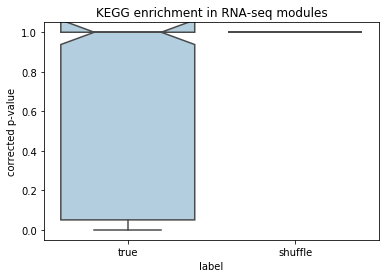

In [54]:
h = sns.boxplot(
    x=rnaseq_kegg_combined["label"],
    y=rnaseq_kegg_combined["corrected p-value"],
    palette="Blues",
    notch=True,
)
h.set_title("KEGG enrichment in RNA-seq modules")

**Takeaway:**

* The p-values that correspond to the over-representation of KEGG pathways within modules is low using both the true module labels and the shuffled module labels. But the shuffled p-values are lower in this case, I'm not sure why.